## Détection et classification des logiciels malveillants sur Android

source 
https://asterius.federation.edu.au/csmining.org/cdmc2020/

AndMal2020-CDMC : 

La menace inégalée des logiciels malveillants Android est à l'origine de divers problèmes de sécurité sur Internet. L'industrie des malwares Android devient de plus en plus perturbatrice avec près de 12 000 nouvelles instances de malwares Android chaque jour. La détection des logiciels malveillants Android dans les smartphones est une cible essentielle pour que la cyber-communauté se débarrasse des échantillons de logiciels malveillants menaçants.

Les logiciels malveillants Android sont l'une des menaces les plus graves sur Internet, qui a connu une recrudescence sans précédent ces dernières années. C'est un défi ouvert pour les experts en cybersécurité. 

La base de données considérée dans ce projet contient une liste plus de 31000 logiciels classés en 12 catégories et 191 familles. L'objectif est de proposer et comparer des algorithmes de machine learning pour identifier automatiquement la catégories de chacun des logiciels. 

Les données sont collectées à partir des fichiers au format Exceutable Linkage Format et recodées de la façon suivante. Les 2000 premiers  octets du fichier sont extraits. Des 0 sont  ajoutés si le fichier n'est pas assez long. Ces chaînes ASCII sont ensuite encodées par un simple code de chiffrement pour supprimer les informations sensibles et transmises à un encodeur base64 pour obtenir des représentations radix-64 lisibles. 

La catégorie et la famille de chaque logiciel est déterminée par des moteurs antivirus.
 
 Chaque ligne du fichier de données correspond donc à un programme excécutable. Les 2493 premières colonnes sont le résultat du chiffrage.  La colonne 2494 est le hash (identifiant). Et les 3 dernières colonnes donnent des informations sur le type de logiciel (famille, malveillant ou non). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA


from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate, ShuffleSplit, GridSearchCV

from sklearn import neighbors, linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 

## 1 - Importation des données

In [2]:
nb_binome = 18022495 # nombre à remplacer par votre numéro de binome
np.random.seed(nb_binome)

In [3]:
n  = 31405
p = 0.1
Skiprows =  np.where(np.random.uniform(size=(n))>p)[0]

varnames = [str(i) for i in range(2497)]
data1 = pd.read_csv("https://perso.univ-rennes1.fr/valerie.monbet/MachineLearning/AndroidMalware_Training_set.csv",
                  sep=",",skiprows=Skiprows,
                  names = varnames,
                  header=None)

In [4]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496
0,84,0,0.0,3,22,16,7,28,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,e4c183e206c81a642711390b3fde726a,skymobi,Riskware,Malware
1,79,0,0.0,2,12,2,0,23,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,58fcb5e5fe9f370b900365f62d9ba630,smspay,Riskware,Malware
2,425,1,0.0,26,75,4,4,29,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,358ed4fb0688dbf3899bb027b2f5ba62,smspay,Riskware,Malware
3,84,0,0.0,14,22,11,2,28,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,d3201aa24a946e2429678f24c642e5e3,smsreg,Riskware,Malware
4,313,0,0.0,4,13,10,13,37,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,c6e8716da354a4ff6f90925508e66fdc,smspay,Riskware,Malware


**On retire les colonnes  2493 (hash : identifiants), 2494 (famille), 2496 (Malware ou non). Ces informations ne nous aiderons pas pour la classification**

In [5]:
data1 = data1.drop(['2493','2494','2496'], axis = 1)

In [6]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,2484,2485,2486,2487,2488,2489,2490,2491,2492,2495
0,84,0,0.0,3,22,16,7,28,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Riskware
1,79,0,0.0,2,12,2,0,23,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Riskware
2,425,1,0.0,26,75,4,4,29,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Riskware
3,84,0,0.0,14,22,11,2,28,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Riskware
4,313,0,0.0,4,13,10,13,37,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Riskware


Text(0.5, 1.0, 'categorie')

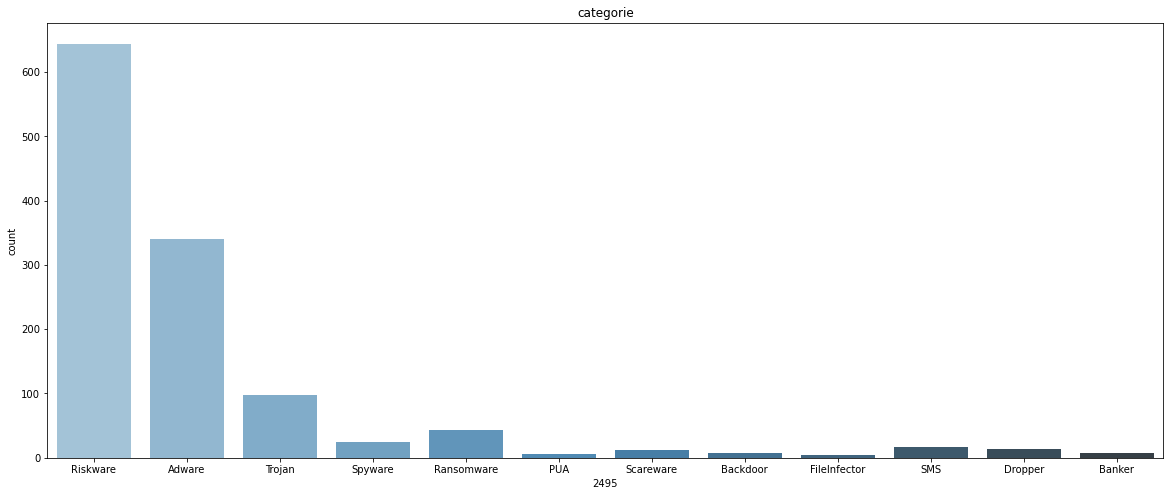

In [7]:
plt.figure(figsize=(20,8))
sns.countplot(x="2495",data=data1,palette="Blues_d")
plt.title("categorie")

**On regarde les variables dont la variance est nulle donc dont l'information est inutile et on retire ces colonnes.**

In [8]:
sd = data1.std()
print(sd.shape)
print("Variables avec écart-type nul : ",np.where(sd==0))
print("Variables avec écart-type non défini : ",np.where(np.isnan(sd)))

data = data1.drop( np.array(np.where(sd==0)[0],dtype = str) , axis = 1)

(2493,)
Variables avec écart-type nul :  (array([  30,   42,   70, ..., 2490, 2491, 2492]),)
Variables avec écart-type non défini :  (array([], dtype=int64),)


/tmp/ipykernel_3888/1140024124.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sd = data1.std()


**La colonne qui va nous intéresser est la colonne 2495. On veut avoir des données binaires pour pouvoir les interpréter. On transforme donc les données en tableau numpy. A changer selon la catégorie voulue dans l'ordre alphabétique (Adware, Backdoor, Banker, Dropper, Fileinfector, PUA, Ransomware, Riskware, Scareware, SMS, Spyware,   Trojan).**

In [9]:
data_np = data.to_numpy()

X = data_np[:,:-1]
Y = data_np[:,-1]

## Préparation des données pour le machine learning
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

In [10]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# K Neigbors 

In [12]:
# Generation de B ensemble d'entrainement/validation 
B = 5
cv = KFold(n_splits=B, random_state=None, shuffle=True)
knn = neighbors.KNeighborsClassifier()
param_grid = [{'n_neighbors': [1,5,10,20,30], 
               'weights': ['uniform','distance'],
               'algorithm': ['auto', 'ball_tree', 'brute'],
               'leaf_size': [5,10,20,30,40],
               'metric': ['euclidean','manhattan']}]
# Optimization of the hyperparameters
search_knn = GridSearchCV(knn, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1) # n_jobs=-1 permet d'utiliser tous les processeurs (calcul parallèle)
search_knn.fit(X_train,y_train)
print('Meilleur modèle')
print(search_knn.best_estimator_)

Meilleur modèle
KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='manhattan',
                     weights='distance')


In [13]:
y_pred_knn = search_knn.best_estimator_.predict(X_test)

Confusion matrix (proportions) : 
[[0.8 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.  0.  0.  0.2 0.4 0.  0.  0.2]
 [0.5 0.  0.2 0.  0.  0.  0.2 0.  0.  0.  0.  0. ]
 [0.3 0.  0.  0.3 0.  0.  0.  0.  0.  0.  0.  0.3]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0. ]
 [0.2 0.  0.1 0.  0.  0.  0.7 0.  0.  0.  0.  0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.  0. ]
 [0.4 0.  0.1 0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.3 0.  0.1 0.  0.  0.  0.  0.1 0.  0.3 0.  0.1]
 [0.  0.  0.1 0.  0.  0.  0.2 0.  0.  0.  0.5 0.1]
 [0.3 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.5]]
 


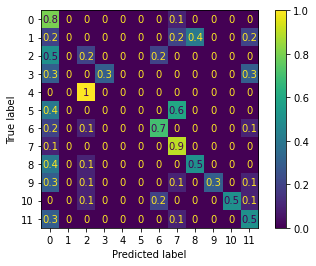

In [14]:
print("Confusion matrix (proportions) : ")
cm = np.round(confusion_matrix(y_test,y_pred_knn,normalize='true'),1)
print(np.round(cm,2))
print(' ')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [15]:
print("Score pour KNeighbors")
print("accuracy:", np.round(accuracy_score(y_test,y_pred_knn),3))
print("precision", np.round(precision_score(y_test,y_pred_knn, average = 'macro'),3))
print("recall", np.round(recall_score(y_test,y_pred_knn, average = 'macro'),3))
print("f1 score" , np.round(f1_score(y_test,y_pred_knn, average = 'macro'),3))

Score pour KNeighbors
accuracy: 0.802
precision 0.51
recall 0.396
f1 score 0.423


/home/kevin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [16]:
B = 5
cv = KFold(n_splits=B, random_state=4, shuffle=True)

clf = DecisionTreeClassifier()
param_grid = [{'criterion': ['gini', 'entropy'],
               'splitter': ['best','random'],
               'max_depth': [5,10,15,20,25],
               'max_features': ['auto', 'sqrt', 'log2']}]
# Optimization of the hyperparameters
search_tree = GridSearchCV(clf, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1) # n_jobs=-1 permet d'utiliser tous les processeurs (calcul parallèle)
search_tree.fit(X_train,y_train)
print('Meilleur modèle')
print(search_tree.best_estimator_)

Meilleur modèle
DecisionTreeClassifier(criterion='entropy', max_depth=25, max_features='log2')


Confusion matrix (proportions) : 
[[0.8 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.6]
 [0.2 0.  0.2 0.  0.  0.  0.2 0.  0.  0.  0.2 0. ]
 [0.2 0.  0.  0.3 0.  0.  0.  0.1 0.  0.1 0.  0.2]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.6 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.2]
 [0.  0.  0.  0.2 0.  0.  0.5 0.1 0.  0.1 0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.1 0.2 0.6 0.  0.  0.1]
 [0.  0.1 0.  0.  0.  0.  0.  0.1 0.1 0.3 0.  0.3]
 [0.1 0.  0.  0.  0.  0.  0.1 0.1 0.2 0.  0.3 0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.7]]
 


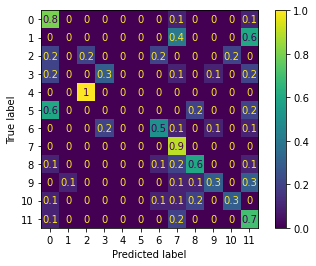

In [17]:
y_pred_tree = search_tree.best_estimator_.predict(X_test)
print("Confusion matrix (proportions) : ")
cm = np.round(confusion_matrix(y_test,y_pred_tree,normalize='true'),1)
print(np.round(cm,2))
print(' ')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [38]:
print("Score pour Decision Tree")
print("accuracy:", np.round(accuracy_score(y_test,y_pred_tree),3))
print("precision", np.round(precision_score(y_test,y_pred_tree, average = 'weighted'),3))
print("recall", np.round(recall_score(y_test,y_pred_tree, average = 'weighted'),3))
print("f1 score" , np.round(f1_score(y_test,y_pred_tree, average = 'weighted'),3))

Score pour Decision Tree
accuracy: 0.785
precision 0.796
recall 0.785
f1 score 0.787


/home/kevin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest

In [22]:
B = 5
cv = KFold(n_splits=B, random_state=4, shuffle=True)

param_grid = {'criterion': ['gini', 'entropy'],  
              'max_depth': [3,5,10,20],
              'max_features': [10,15,20,30,40]}

rf = RandomForestClassifier()
search_rf = GridSearchCV(rf, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search_rf.fit(X_train,y_train)
print('Meilleur modèle')
print(search_rf.best_estimator_)

Meilleur modèle
RandomForestClassifier(max_depth=10, max_features=30)


Confusion matrix (proportions) : 
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.2]
 [0.2 0.  0.2 0.  0.  0.  0.2 0.2 0.  0.  0.  0. ]
 [0.4 0.  0.  0.3 0.  0.  0.1 0.  0.  0.  0.  0.1]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.2 0.  0.  0.7 0.  0.  0.  0.  0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.  0.  0.1 0.  0.4 0.  0.  0.3]
 [0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.3]
 [0.2 0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.4 0. ]
 [0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]]
 


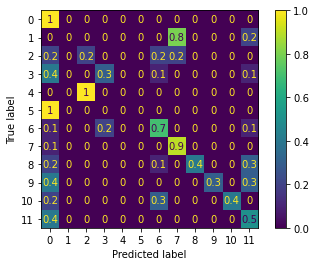

In [23]:
y_pred_rf = search_rf.best_estimator_.predict(X_test)
print("Confusion matrix (proportions) : ")
cm = np.round(confusion_matrix(y_test,y_pred_rf,normalize='true'),1)
print(np.round(cm,2))
print(' ')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [24]:
print("Score pour Random Forest")
print("accuracy:", np.round(accuracy_score(y_test,y_pred_rf),3))
print("precision", np.round(precision_score(y_test,y_pred_rf, average = 'macro'),3))
print("recall", np.round(recall_score(y_test,y_pred_rf, average = 'macro'),3))
print("f1 score" , np.round(f1_score(y_test,y_pred_rf, average = 'macro'),3))

Score pour Random Forest
accuracy: 0.838
precision 0.483
recall 0.395
f1 score 0.417


/home/kevin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# AdaBoost

In [25]:
param_grid = {'n_estimators':[10,30,50,60,80], 
             'learning_rate':[0.001,0.01, 0.1,1]}

ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
search_ad= GridSearchCV(ad, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search_ad.fit(X_train,y_train)
print('Meilleur modèle')
print(search_ad.best_estimator_)

Meilleur modèle
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.01)


In [26]:
y_pred_ad = search_ad.best_estimator_.predict(X_test)

Confusion matrix (proportions) : 
[[0.9 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
 [0.2 0.  0.2 0.  0.  0.  0.2 0.2 0.  0.  0.  0. ]
 [0.2 0.  0.  0.3 0.  0.  0.  0.2 0.  0.  0.1 0.1]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2]
 [0.1 0.  0.  0.1 0.  0.  0.7 0.  0.  0.  0.  0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.1 0.1 0.5 0.  0.  0.2]
 [0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.3]
 [0.1 0.  0.  0.  0.  0.  0.2 0.4 0.  0.  0.  0.1]
 [0.2 0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.5]]
 


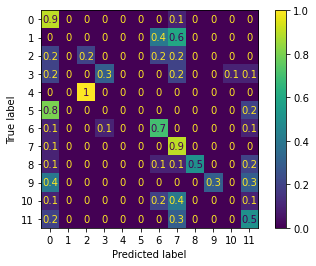

In [27]:
print("Confusion matrix (proportions) : ")
cm = np.round(confusion_matrix(y_test,y_pred_ad,normalize='true'),1)
print(np.round(cm,2))
print(' ')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [28]:
print("Score pour AdaBoost")
print("accuracy:", np.round(accuracy_score(y_test,y_pred_ad),3))
print("precision", np.round(precision_score(y_test,y_pred_ad, average = 'macro'),3))
print("recall", np.round(recall_score(y_test,y_pred_ad, average = 'macro'),3))
print("f1 score" , np.round(f1_score(y_test,y_pred_ad, average = 'macro'),3))

Score pour AdaBoost
accuracy: 0.815
precision 0.48
recall 0.366
f1 score 0.389


/home/kevin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Boosting

In [29]:
param_grid = {'n_estimators':[30,50,60,80], 
             'learning_rate':[0.001,0.01, 0.1,1],
             'criterion': ['friedman_mse', 'squared_error'],
             'max_features': [5,10,15,20]}

gb = GradientBoostingClassifier()
search_gb= GridSearchCV(gb, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search_gb.fit(X_train,y_train)
print('Meilleur modèle')
print(search_gb.best_estimator_)

Meilleur modèle
GradientBoostingClassifier(max_features=10, n_estimators=60)


In [30]:
y_pred_gb = search_gb.best_estimator_.predict(X_test)

Confusion matrix (proportions) : 
[[0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.2]
 [0.2 0.  0.2 0.  0.  0.  0.2 0.2 0.  0.  0.  0. ]
 [0.3 0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.2]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.1 0.  0.  0.6 0.  0.  0.  0.  0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.4]
 [0.4 0.  0.  0.  0.  0.  0.  0.1 0.  0.3 0.  0.1]
 [0.5 0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.2 0.1]
 [0.3 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.5]]
 


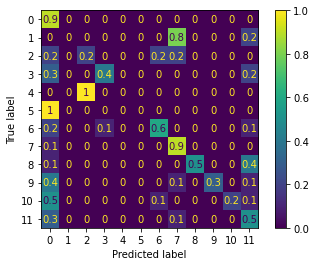

In [31]:
print("Confusion matrix (proportions) : ")
cm = np.round(confusion_matrix(y_test,y_pred_gb,normalize='true'),1)
print(np.round(cm,2))
print(' ')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [32]:
print("Score pour Gradient boost")
print("accuracy:", np.round(accuracy_score(y_test,y_pred_gb),3))
print("precision", np.round(precision_score(y_test,y_pred_gb, average = 'macro'),3))
print("recall", np.round(recall_score(y_test,y_pred_gb, average = 'macro'),3))
print("f1 score" , np.round(f1_score(y_test,y_pred_gb, average = 'macro'),3))

Score pour Gradient boost
accuracy: 0.817
precision 0.525
recall 0.385
f1 score 0.419


/home/kevin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Tableau de comparaison

| Méthode| accuracy | precision | recall | F1- score|
| :-: | :-:  | :-: |  :-: |  :-: |
| KNeighbors | 0.802 | 0.51 | 0.396 | 0.423|
| Decision tree | 0.775 | 0.375 |0.38|0.369|
| Random forest | 0.833 | 0.473 |0.388|0.413|
| Adaboost | 0.815 | 0.479 |0.365|0.388|
| Gradient boost | 0.844 | 0.456 | 0.418 | 0.426 | 